## Import necessary libraries

In [1]:
import os
from glob import glob
from tqdm.notebook import tqdm
import pickle


import cv2
import numpy as np
import matplotlib.pyplot as plt


import sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import utils 
import tensorflow as tf

## feature extractors
from SimpleITK import GetImageFromArray
from radiomics import glrlm, glcm, gldm

In [2]:
import logging
# set level for all classes
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

In [3]:
## Consistently create same random numpy array
np.random.seed(42)

## Define path of prepared data

In [4]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

classes = ["benign", "malignant", "normal"]

saved_directory = "prepared_data"
saved_filename = "image_with_mask_label.pickle"

result_path = "results"
os.makedirs(result_path, exist_ok=True)

## Load Data

In [5]:
with open(os.path.join(saved_directory, saved_filename), 'rb') as handle:
    data = pickle.load(handle)

In [6]:
N_labels = {
    'benign': 0,
    'malignant': 0,
    'normal': 0
}

for datum in data:
    label = datum["label"]
    if label == 0 :
        N_labels["benign"] += 1
    elif label == 1:
        N_labels["malignant"] += 1
    elif label ==2:
        N_labels["normal"] += 1
    else:
        raise ValueError('Label not valid!')

In [7]:
N_labels

{'benign': 437, 'malignant': 210, 'normal': 133}

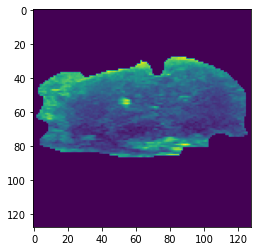

In [8]:
index = 437

plt.figure()
plt.imshow(data[index]["image"] * data[index]["mask"])

## Extract Grey-Level Difference Matrix (GLDM) features

In [11]:
gldmFeat = []
labels = []

for datum in tqdm(data[:(N_labels["benign"] + N_labels["malignant"])]): 
    
    datum_image = datum["image"].copy()
    datum_mask = datum["mask"].copy()
    
    gldmFeatures = gldm.RadiomicsGLDM(GetImageFromArray(datum_image),
                                      GetImageFromArray(datum_mask),
                                      verbose=False)
    
    
    gldmFeat.append(gldmFeatures.execute())
    
    labels.append(datum["label"])


extracted_features = []
keys = list(gldmFeat[0].keys())

for datum in gldmFeat:
    buff = []
    for key in keys:
        buff.append(datum[key])

    extracted_features.append(buff)

extracted_features = np.array(extracted_features)
extracted_features = (extracted_features - extracted_features.mean(axis=0)) / (extracted_features.std(axis=0) + 1e-8)

labels = np.array(labels)

  0%|          | 0/647 [00:00<?, ?it/s]

In [12]:
## GLDM feature names
keys

['DependenceEntropy',
 'DependenceNonUniformity',
 'DependenceNonUniformityNormalized',
 'DependenceVariance',
 'GrayLevelNonUniformity',
 'GrayLevelVariance',
 'HighGrayLevelEmphasis',
 'LargeDependenceEmphasis',
 'LargeDependenceHighGrayLevelEmphasis',
 'LargeDependenceLowGrayLevelEmphasis',
 'LowGrayLevelEmphasis',
 'SmallDependenceEmphasis',
 'SmallDependenceHighGrayLevelEmphasis',
 'SmallDependenceLowGrayLevelEmphasis']

## Train Validation Split

In [13]:
indices = np.random.permutation(len(labels))

In [14]:
n_train = int(0.8 * len(labels))

train_x, train_y = extracted_features[indices[:n_train]], labels[indices[:n_train]]
validation_x, validation_y = extracted_features[indices[n_train:]], labels[indices[n_train:]]

print(f"train input shape : {train_x.shape}")
print(f"validation input shape : {validation_x.shape}")

train input shape : (517, 14)
validation input shape : (130, 14)


## Multi-Layer Perceptron (MLP) Classifier

In [15]:
tf.keras.backend.clear_session()

mlp_save_path = os.path.join(result_path, "GLDM_MLP")
os.makedirs(mlp_save_path, exist_ok=True)

epochs = 300 # number of epochs

In [16]:
## Define evaluating criterias

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [17]:
# Define Callbacks

def LearningRateScheduler():
    def scheduler(epoch, lr):
        if epoch < 50:
            return lr
        else:
            if epoch % 30 == 0:
                lr = lr * tf.math.exp(-0.10)
        return lr
    return tf.keras.callbacks.LearningRateScheduler(scheduler)

show_progress = utils.ShowProgress(epochs) # for clean progress bar
best_weight = utils.BestModelWeights() # return best model weight on validation data

In [18]:
## Define model and compile it

mlp_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(14,)),
    
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])


mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # optimizer
                  loss=tf.keras.losses.BinaryCrossentropy(), # loss function
                  metrics=METRICS, # metrics for evaluate our model
                  )

In [19]:
#Train 
history = mlp_model.fit(train_x, train_y,
                        epochs=epochs,
                        validation_data=(validation_x, validation_y),
                        callbacks=[show_progress, best_weight, LearningRateScheduler()],
                        verbose=0 # When you want to use ShowProgress callback, you should set verbose to zero
                        )

  0%|          | 0/300 [00:00<?, ?it/s]


Best weights is set, Best Epoch was : 154



### Plot and print MLP results

In [20]:
print("Train Metrics : ")
_ = mlp_model.evaluate(train_x, train_y)

Train Metrics : 
17/17 [==============================] - 0s 3ms/step - loss: 0.3154 - tp: 119.0000 - fp: 32.0000 - tn: 320.0000 - fn: 46.0000 - accuracy: 0.8491 - precision: 0.7881 - recall: 0.7212 - auc: 0.9322 - prc: 0.8717


In [21]:
print("Validation Metrics : ")
_ = mlp_model.evaluate(validation_x, validation_y)

Validation Metrics : 
5/5 [==============================] - 0s 3ms/step - loss: 0.4103 - tp: 31.0000 - fp: 7.0000 - tn: 78.0000 - fn: 14.0000 - accuracy: 0.8385 - precision: 0.8158 - recall: 0.6889 - auc: 0.8833 - prc: 0.8246


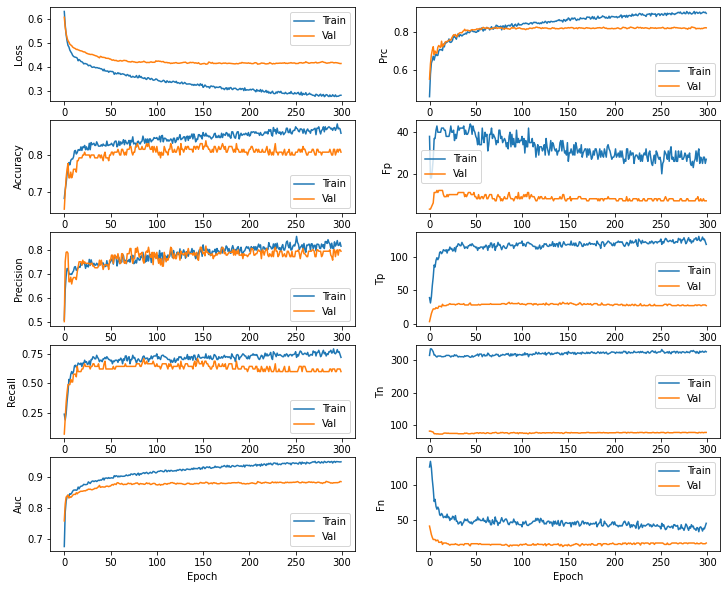

In [22]:
save_filename = os.path.join(mlp_save_path, "criteria_over_epoch.jpg")

utils.plot_metrics(history)
plt.savefig(save_filename, dpi=150, bbox_inches="tight")

5/5 [==============================] - 0s 2ms/step


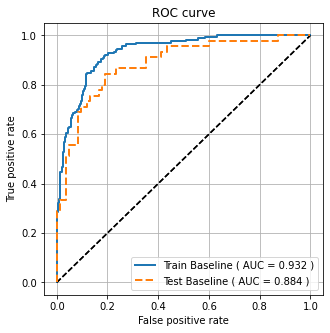

In [23]:
save_filename = os.path.join(mlp_save_path, "train_val_roc.jpg")

plt.figure(figsize=(5,5))
utils.plot_roc("Train Baseline",
               train_y,
               mlp_model.predict(train_x),
               color=colors[0])
utils.plot_roc("Test Baseline",
                validation_y,
                mlp_model.predict(validation_x),
                color=colors[1],
                linestyle='--')

plt.legend(loc='lower right');
plt.savefig(save_filename, dpi=150, bbox_inches="tight")

5/5 [==============================] - 0s 2ms/step


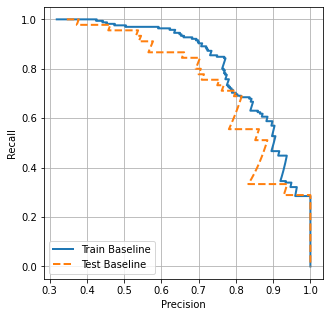

In [24]:
save_filename = os.path.join(mlp_save_path, "train_val_prc.jpg")

plt.figure(figsize=(5,5))
utils.plot_prc("Train Baseline",
               train_y,
               mlp_model.predict(train_x),
               color=colors[0])
utils.plot_prc("Test Baseline",
               validation_y,
               mlp_model.predict(validation_x),
               color=colors[1],
               linestyle='--')

plt.legend(loc='lower left');
plt.savefig(save_filename, dpi=150, bbox_inches="tight")

5/5 [==============================] - 0s 2ms/step


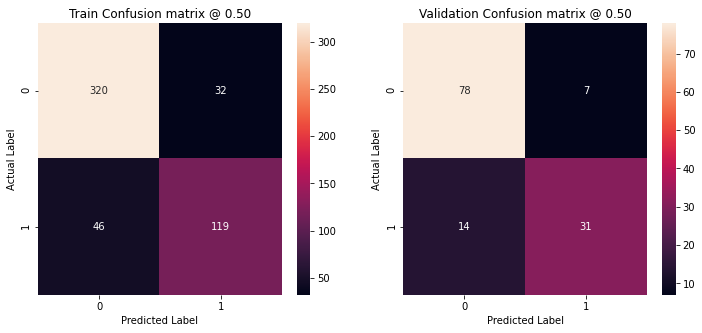

In [25]:
save_filename = os.path.join(mlp_save_path, "train_val_confusionmatrix.jpg")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
utils.plot_cm("Train",
              train_y,
              mlp_model.predict(train_x))
plt.subplot(1,2,2)
utils.plot_cm("Validation",
              validation_y,
              mlp_model.predict(validation_x))

plt.savefig(save_filename, dpi=150, bbox_inches="tight")

## K-Nearest Neighbors (KNN) Classifier

In [26]:
knn_save_path = os.path.join(result_path, "GLDM_KNN")
os.makedirs(knn_save_path, exist_ok=True)

In [27]:
knn_model = KNeighborsClassifier(n_neighbors=5)

In [28]:
knn_model.fit(train_x, train_y)

KNeighborsClassifier()

### Plot and print KNN results

In [29]:
predicted = knn_model.predict_proba(train_x)[:,1]
fpr, tpr, thresholds = sklearn.metrics.roc_curve(train_y, predicted)
cm = sklearn.metrics.confusion_matrix(train_y, (predicted > 0.5).astype(np.int32))

knn_metrics = {
    "accuarcy": sklearn.metrics.accuracy_score(train_y, (predicted > 0.5).astype(np.int32)),
    "recall": sklearn.metrics.recall_score(train_y, (predicted > 0.5).astype(np.int32)),
    "precision": sklearn.metrics.precision_score(train_y, (predicted > 0.5).astype(np.int32)),
    "auc": sklearn.metrics.auc(fpr, tpr),
    "prc": sklearn.metrics.average_precision_score(train_y, predicted),
    "tp": cm[0,0],
    "fp": cm[0,1],
    "fn": cm[1,0],
    "tn": cm[1,1],
}

print("Train Metrics : ")
print(knn_metrics)

Train Metrics : 
{'accuarcy': 0.8665377176015474, 'recall': 0.7575757575757576, 'precision': 0.8116883116883117, 'auc': 0.9320420110192837, 'prc': 0.8280873362024612, 'tp': 323, 'fp': 29, 'fn': 40, 'tn': 125}


In [30]:
predicted = knn_model.predict_proba(validation_x)[:,1]
fpr, tpr, thresholds = sklearn.metrics.roc_curve(validation_y, predicted)
val_cm = sklearn.metrics.confusion_matrix(validation_y, (predicted > 0.5).astype(np.int32))

knn_metrics = {
    "val_accuarcy": sklearn.metrics.accuracy_score(validation_y, (predicted > 0.5).astype(np.int32)),
    "val_recall": sklearn.metrics.recall_score(validation_y, (predicted > 0.5).astype(np.int32)),
    "val_precision": sklearn.metrics.precision_score(validation_y, (predicted > 0.5).astype(np.int32)),
    "val_auc": sklearn.metrics.auc(fpr, tpr),
    "val_prc": sklearn.metrics.average_precision_score(validation_y, predicted),
    "val_tp": val_cm[0,0],
    "val_fp": val_cm[0,1],
    "val_fn": val_cm[1,0],
    "val_tn": val_cm[1,1],
}

print("Validation Metrics : ")
print(knn_metrics)

Validation Metrics : 
{'val_accuarcy': 0.8076923076923077, 'val_recall': 0.7777777777777778, 'val_precision': 0.7, 'val_auc': 0.8303267973856209, 'val_prc': 0.6631613164197433, 'val_tp': 70, 'val_fp': 15, 'val_fn': 10, 'val_tn': 35}


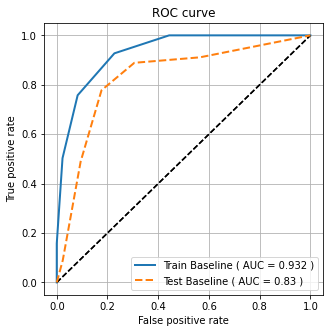

In [31]:
save_filename = os.path.join(knn_save_path, "train_val_roc.jpg")

plt.figure(figsize=(5,5))
utils.plot_roc("Train Baseline",
               train_y,
               knn_model.predict_proba(train_x)[:,1],
               color=colors[0])
utils.plot_roc("Test Baseline",
                validation_y,
                knn_model.predict_proba(validation_x)[:,1],
                color=colors[1],
                linestyle='--')

plt.legend(loc='lower right');
plt.savefig(save_filename, dpi=150, bbox_inches="tight")

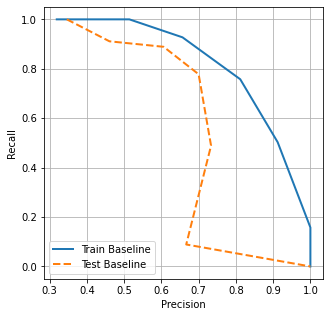

In [32]:
save_filename = os.path.join(knn_save_path, "train_val_prc.jpg")

plt.figure(figsize=(5,5))
utils.plot_prc("Train Baseline",
               train_y,
               knn_model.predict_proba(train_x)[:,1],
               color=colors[0])
utils.plot_prc("Test Baseline",
               validation_y,
               knn_model.predict_proba(validation_x)[:,1],
               color=colors[1],
               linestyle='--')

plt.legend(loc='lower left');
plt.savefig(save_filename, dpi=150, bbox_inches="tight")

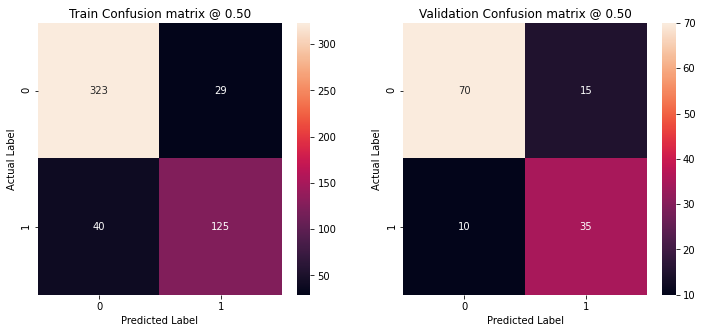

In [33]:
save_filename = os.path.join(knn_save_path, "train_val_confusionmatrix.jpg")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
utils.plot_cm("Train",
              train_y,
              knn_model.predict_proba(train_x)[:,1],
             )
plt.subplot(1,2,2)
utils.plot_cm("Validation",
              validation_y,
              knn_model.predict_proba(validation_x)[:,1],
             )

plt.savefig(save_filename, dpi=150, bbox_inches="tight")

## Linear Support Vector Machine (SVM) Classifier

In [34]:
lsvm_save_path = os.path.join(result_path, "GLDM_LSVM")
os.makedirs(lsvm_save_path, exist_ok=True)

In [35]:
lsvm_model = SVC(probability=True, kernel='linear')

In [36]:
lsvm_model.fit(train_x, train_y)

SVC(kernel='linear', probability=True)

### Plot and print SVM results

In [37]:
predicted = lsvm_model.predict_proba(train_x)[:,1]
cm = sklearn.metrics.confusion_matrix(train_y, (predicted > 0.5).astype(np.int32))

lsvm_metrics = {
    "accuarcy": sklearn.metrics.accuracy_score(train_y, (predicted > 0.5).astype(np.int32)),
    "recall": sklearn.metrics.recall_score(train_y, (predicted > 0.5).astype(np.int32)),
    "precision": sklearn.metrics.precision_score(train_y, (predicted > 0.5).astype(np.int32)),
    "auc": sklearn.metrics.auc(fpr, tpr),
    "prc": sklearn.metrics.average_precision_score(train_y, predicted),
    "tp": cm[0,0],
    "fp": cm[0,1],
    "fn": cm[1,0],
    "tn": cm[1,1],
}

print("Train Metrics : ")
print(lsvm_metrics)

Train Metrics : 
{'accuarcy': 0.8123791102514507, 'recall': 0.6181818181818182, 'precision': 0.75, 'auc': 0.8303267973856209, 'prc': 0.7244373733735829, 'tp': 318, 'fp': 34, 'fn': 63, 'tn': 102}


In [38]:
predicted = lsvm_model.predict_proba(validation_x)[:,1]
val_cm = sklearn.metrics.confusion_matrix(validation_y, (predicted > 0.5).astype(np.int32))

lsvm_metrics = {
    "val_accuarcy": sklearn.metrics.accuracy_score(validation_y, (predicted > 0.5).astype(np.int32)),
    "val_recall": sklearn.metrics.recall_score(validation_y, (predicted > 0.5).astype(np.int32)),
    "val_precision": sklearn.metrics.precision_score(validation_y, (predicted > 0.5).astype(np.int32)),
    "val_auc": sklearn.metrics.auc(fpr, tpr),
    "val_prc": sklearn.metrics.average_precision_score(validation_y, predicted),
    "val_tp": val_cm[0,0],
    "val_fp": val_cm[0,1],
    "val_fn": val_cm[1,0],
    "val_tn": val_cm[1,1],
}

print("Validation Metrics : ")
print(lsvm_metrics)

Validation Metrics : 
{'val_accuarcy': 0.7923076923076923, 'val_recall': 0.6, 'val_precision': 0.75, 'val_auc': 0.8303267973856209, 'val_prc': 0.779397316857028, 'val_tp': 76, 'val_fp': 9, 'val_fn': 18, 'val_tn': 27}


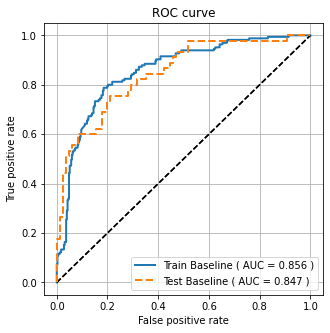

In [39]:
save_filename = os.path.join(lsvm_save_path, "train_val_roc.jpg")

plt.figure(figsize=(5,5))
utils.plot_roc("Train Baseline",
               train_y,
               lsvm_model.predict_proba(train_x)[:,1],
               color=colors[0])
utils.plot_roc("Test Baseline",
                validation_y,
                lsvm_model.predict_proba(validation_x)[:,1],
                color=colors[1],
                linestyle='--')

plt.legend(loc='lower right');
plt.savefig(save_filename, dpi=150, bbox_inches="tight")

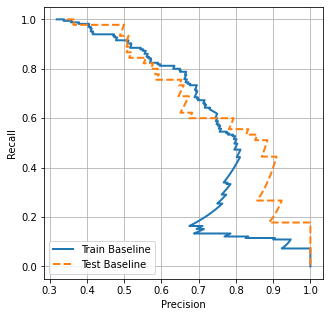

In [40]:
save_filename = os.path.join(lsvm_save_path, "train_val_prc.jpg")

plt.figure(figsize=(5,5))
utils.plot_prc("Train Baseline",
               train_y,
               lsvm_model.predict_proba(train_x)[:,1],
               color=colors[0])
utils.plot_prc("Test Baseline",
               validation_y,
               lsvm_model.predict_proba(validation_x)[:,1],
               color=colors[1],
               linestyle='--')

plt.legend(loc='lower left');
plt.savefig(save_filename, dpi=150, bbox_inches="tight")

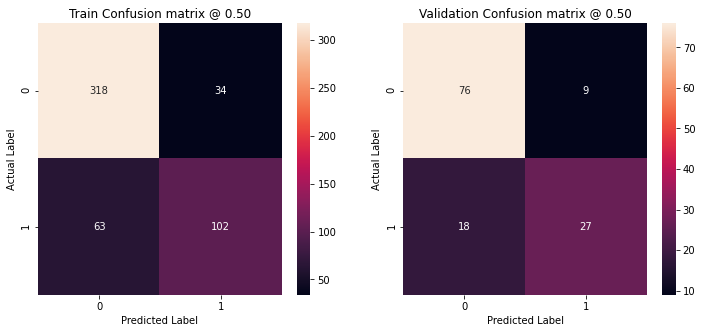

In [41]:
save_filename = os.path.join(lsvm_save_path, "train_val_confusionmatrix.jpg")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
utils.plot_cm("Train",
              train_y,
              lsvm_model.predict_proba(train_x)[:,1],
             )
plt.subplot(1,2,2)
utils.plot_cm("Validation",
              validation_y,
              lsvm_model.predict_proba(validation_x)[:,1],
             )

plt.savefig(save_filename, dpi=150, bbox_inches="tight")

## RBF Support Vector Machine (SVM) Classifier

In [42]:
nlsvm_save_path = os.path.join(result_path, "GLDM_NLSVM")
os.makedirs(nlsvm_save_path, exist_ok=True)

In [43]:
nlsvm_model = SVC(probability=True, kernel='rbf')

In [44]:
nlsvm_model.fit(train_x, train_y)

SVC(probability=True)

### Plot and print SVM results

In [45]:
predicted = nlsvm_model.predict_proba(train_x)[:,1]
cm = sklearn.metrics.confusion_matrix(train_y, (predicted > 0.5).astype(np.int32))

nlsvm_metrics = {
    "accuarcy": sklearn.metrics.accuracy_score(train_y, (predicted > 0.5).astype(np.int32)),
    "recall": sklearn.metrics.recall_score(train_y, (predicted > 0.5).astype(np.int32)),
    "precision": sklearn.metrics.precision_score(train_y, (predicted > 0.5).astype(np.int32)),
    "auc": sklearn.metrics.auc(fpr, tpr),
    "prc": sklearn.metrics.average_precision_score(train_y, predicted),
    "tp": cm[0,0],
    "fp": cm[0,1],
    "fn": cm[1,0],
    "tn": cm[1,1],
}

print("Train Metrics : ")
print(nlsvm_metrics)

Train Metrics : 
{'accuarcy': 0.8220502901353965, 'recall': 0.6424242424242425, 'precision': 0.762589928057554, 'auc': 0.8303267973856209, 'prc': 0.7704985778185102, 'tp': 319, 'fp': 33, 'fn': 59, 'tn': 106}


In [46]:
predicted = nlsvm_model.predict_proba(validation_x)[:,1]
val_cm = sklearn.metrics.confusion_matrix(validation_y, (predicted > 0.5).astype(np.int32))

nlsvm_metrics = {
    "val_accuarcy": sklearn.metrics.accuracy_score(validation_y, (predicted > 0.5).astype(np.int32)),
    "val_recall": sklearn.metrics.recall_score(validation_y, (predicted > 0.5).astype(np.int32)),
    "val_precision": sklearn.metrics.precision_score(validation_y, (predicted > 0.5).astype(np.int32)),
    "val_auc": sklearn.metrics.auc(fpr, tpr),
    "val_prc": sklearn.metrics.average_precision_score(validation_y, predicted),
    "val_tp": val_cm[0,0],
    "val_fp": val_cm[0,1],
    "val_fn": val_cm[1,0],
    "val_tn": val_cm[1,1],
}

print("Validation Metrics : ")
print(nlsvm_metrics)

Validation Metrics : 
{'val_accuarcy': 0.8, 'val_recall': 0.6, 'val_precision': 0.7714285714285715, 'val_auc': 0.8303267973856209, 'val_prc': 0.7786903595414972, 'val_tp': 77, 'val_fp': 8, 'val_fn': 18, 'val_tn': 27}


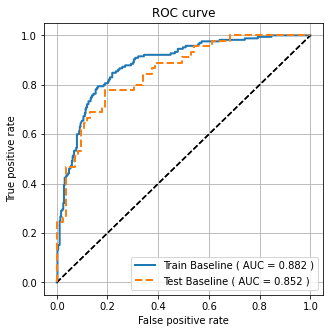

In [47]:
save_filename = os.path.join(nlsvm_save_path, "train_val_roc.jpg")

plt.figure(figsize=(5,5))
utils.plot_roc("Train Baseline",
               train_y,
               nlsvm_model.predict_proba(train_x)[:,1],
               color=colors[0])
utils.plot_roc("Test Baseline",
                validation_y,
                nlsvm_model.predict_proba(validation_x)[:,1],
                color=colors[1],
                linestyle='--')

plt.legend(loc='lower right');
plt.savefig(save_filename, dpi=150, bbox_inches="tight")

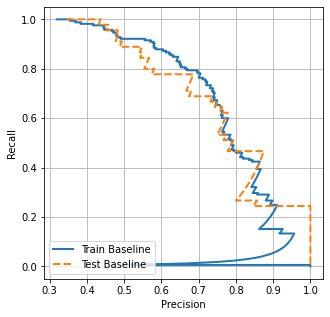

In [48]:
save_filename = os.path.join(nlsvm_save_path, "train_val_prc.jpg")

plt.figure(figsize=(5,5))
utils.plot_prc("Train Baseline",
               train_y,
               nlsvm_model.predict_proba(train_x)[:,1],
               color=colors[0])
utils.plot_prc("Test Baseline",
               validation_y,
               nlsvm_model.predict_proba(validation_x)[:,1],
               color=colors[1],
               linestyle='--')

plt.legend(loc='lower left');
plt.savefig(save_filename, dpi=150, bbox_inches="tight")

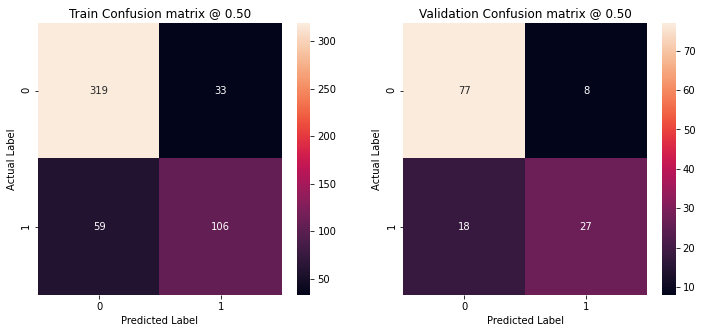

In [49]:
save_filename = os.path.join(nlsvm_save_path, "train_val_confusionmatrix.jpg")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
utils.plot_cm("Train",
              train_y,
              nlsvm_model.predict_proba(train_x)[:,1],
             )
plt.subplot(1,2,2)
utils.plot_cm("Validation",
              validation_y,
              nlsvm_model.predict_proba(validation_x)[:,1],
             )

plt.savefig(save_filename, dpi=150, bbox_inches="tight")

## Plot all Validation ROC and PRC curve together

5/5 [==============================] - 0s 3ms/step


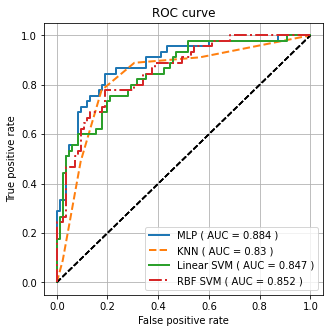

In [50]:
save_filename = os.path.join(result_path, "val_roc_gldm.jpg")

plt.figure(figsize=(5,5))
utils.plot_roc("MLP",
               validation_y,
               mlp_model.predict(validation_x),
               color=colors[0])

utils.plot_roc("KNN",
                validation_y,
                knn_model.predict_proba(validation_x)[:,1],
                color=colors[1],
                linestyle='--')

utils.plot_roc("Linear SVM",
                validation_y,
                lsvm_model.predict_proba(validation_x)[:,1],
                color=colors[2],
                linestyle='-')

utils.plot_roc("RBF SVM",
                validation_y,
                nlsvm_model.predict_proba(validation_x)[:,1],
                color=colors[3],
                linestyle='-.')

plt.legend(loc='lower right');
plt.savefig(save_filename, dpi=150, bbox_inches="tight")

5/5 [==============================] - 0s 2ms/step


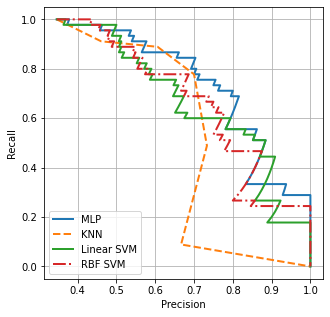

In [51]:
save_filename = os.path.join(result_path, "val_prc_gldm.jpg")

plt.figure(figsize=(5,5))
utils.plot_prc("MLP",
               validation_y,
               mlp_model.predict(validation_x),
               color=colors[0])

utils.plot_prc("KNN",
                validation_y,
                knn_model.predict_proba(validation_x)[:,1],
                color=colors[1],
                linestyle='--')

utils.plot_prc("Linear SVM",
                validation_y,
                lsvm_model.predict_proba(validation_x)[:,1],
                color=colors[2],
                linestyle='-')

utils.plot_prc("RBF SVM",
                validation_y,
                nlsvm_model.predict_proba(validation_x)[:,1],
                color=colors[3],
                linestyle='-.')

plt.legend(loc='lower left');
plt.savefig(save_filename, dpi=150, bbox_inches="tight")